<a href="https://colab.research.google.com/github/435wldms/essa/blob/main/20231103_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06 토픽 모델링 - 20 뉴스 그룹

* 토핑 모델링: 문서 집합에 숨어 있는 주제를 찾아내는 것
* 사람이 수행하는 토픽 모델링과 달리 숨겨진 주제를 효과적으로 표현할 수 있는 중심 단어를 함축적으로 추출
* LSA,LDA 사용

* fetch_20newsgroups() API는 categories 파라미터를 통해 필요한 주제만 필터링해 추출하고 추출된 텍스트를 count 기반으로 벡터화 변환, max_features=1000으로 word 피처의 개수 제한, ngram_range는 (1,2)

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 모토사이클, 야구, 그래픽스, 윈도우즈, 중동, 기독교, 전자공학, 의학 8개 주제를 추출.
cats = ['rec.motorcycles','rec.sport.baseball','comp.graphics','comp.windows.x',
        'talk.politics.mideast','soc.religion.christian','sci.electronics','sci.med']

# 위에서 cats 변수로 기재된 카테고리만 추출. fetch_20newsgroups()의 categories에 cats 입력
news_df = fetch_20newsgroups(subset='all',remove=('headers','footers','quotes'), categories=cats, random_state=0)

# LDA는 Count 기반의 벡터화만 적용합니다.
count_vect = CountVectorizer(max_df=0.95, max_features=1000, min_df=2, stop_words='english',ngram_range=(1,2))

feat_vect = count_vect.fit_transform(news_df.data)
print('CountVectorizer Shape:', feat_vect.shape)

CountVectorizer Shape: (7862, 1000)


-> 7862개의 문서가 1000개의 피처로 구성된 행렬 데이터

* 피처 벡터화된 데이터 세트를 기반으로 LDA 토픽 모델링 수행 (뉴스그룹에서 추출한 주제와 동일하게 8개로 설정)

In [4]:
lda=LatentDirichletAllocation(n_components=8,random_state=0)
lda.fit(feat_vect)

LatentDirichletAllocation(n_components=8, random_state=0)

* components_: 개별 토픽 별로 각 word 피처가 얼마나 많이 그 토픽에 할당됐는지에 대한 수치를 가짐 -> 높은 값일수록 해당 word 피처가 그 토픽의 중심 word가 됨

In [5]:
print(lda.components_.shape)
lda.components_

(8, 1000)


array([[3.60992018e+01, 1.35626798e+02, 2.15751867e+01, ...,
        3.02911688e+01, 8.66830093e+01, 6.79285199e+01],
       [1.25199920e-01, 1.44401815e+01, 1.25045596e-01, ...,
        1.81506995e+02, 1.25097844e-01, 9.39593286e+01],
       [3.34762663e+02, 1.25176265e-01, 1.46743299e+02, ...,
        1.25105772e-01, 3.63689741e+01, 1.25025218e-01],
       ...,
       [3.60204965e+01, 2.08640688e+01, 4.29606813e+00, ...,
        1.45056650e+01, 8.33854413e+00, 1.55690009e+01],
       [1.25128711e-01, 1.25247756e-01, 1.25005143e-01, ...,
        9.17278769e+01, 1.25177668e-01, 3.74575887e+01],
       [5.49258690e+01, 4.47009532e+00, 9.88524814e+00, ...,
        4.87048440e+01, 1.25034678e-01, 1.25074632e-01]])

-> components_array의 0번째 row, 10번째 col에 있는 값은 Topic #0에 대해서 피처 벡터화된 행렬에서 10번쨰 칼럼에 해당하는 피처가 Topic #0에 연관되는 수치 값
* display_topics() 함수를 만들어서 각 토픽 별로 연관도가 높은 순으로 word를 나열

In [6]:
def display_topics(model, feature_names, no_top_words):
  for topic_index, topic in enumerate(model.components_):
    print('Topic #', topic_index)

  # components_array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array 인덱스를 반환.
  topic_word_indexes = topic.argsort()[::-1]
  top_indexes = topic_word_indexes[:no_top_words]

  # top_indexes 대상인 인덱스 별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
  feature_concat = ' '.join([feature_names[i] for i in top_indexes])
  print(feature_concat)

# CountVectorizer 객체 내의 전체 word의 명칭을 get_features_names()를 통해 추출
feature_names = count_vect.get_feature_names_out()

# 토픽 별 가장 연관도가 높은 word를 15개만 추출
display_topics(lda, feature_names,15)

Topic # 0
Topic # 1
Topic # 2
Topic # 3
Topic # 4
Topic # 5
Topic # 6
Topic # 7
use dos thanks windows using window does display help like problem server need know run


* topic #0의 경우 명확하지 않고 일반적인 단어들이 주를 이루고 있고, topic #1은 컴퓨터 그래픽스 영역의 주제어, topic #2는 기독교, topic #3는 의학, topic #4는 윈도우 운영체제, topic #5는 일반적인 단어, topic #6는 중동 분쟁 등에 관련된 주제어, topic #7은 애매하지만 윈도우 운영체제와 관련된 주제어가 일부 추출됨

# 08 문서 유사도

**문서 유사도 측정 방법 - 코사인 유사도**
* 문서와 문서 간 유사도 비교는 일반적으로 코사인 유사도 사용
* 벡터의 크기보다는 벡터의 상호 방향성이 얼마나 유사한지에 기반함

**두 벡터 사잇각**
* 두 벡터의 내적을 총 벡터 크기의 합으로 나눈 것(정규화)

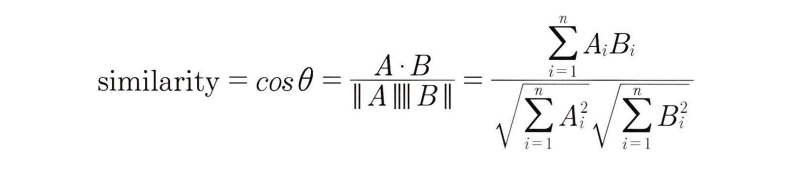

* 코사인 유사도를 주로 사용하는 이유: 차원이 매우 많은 희소 행렬을 기반으로 유사도 지표를 사용하면 정확도가 떨어지기 쉬움, 문서가 매우 길면 단어의 빈도수도 더 많아지는데 빈도수에만 기반해서는 공정한 비교가 어려움
* cos_similarity: 두 개의 넘파이 배열에 대한 코사인 유사도 구하는 함수

In [7]:
import numpy as np

def cos_similarity(v1,v2):
  dot_product = np.dot(v1,v2)
  l2_norm = (np.sqrt(sum(np.square(v1)))*np.sqrt(sum(np.square(v2))))
  similarity = dot_product / l2_norm

  return similarity

* doc_list로 정의된 3개의 간단한 문서의 유사도를 비교하기 위해 이 문서를 TF-IDF로 벡터화된 행렬로 변환

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
doc_list = ['if you take the blue pill, the story ends',
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 17)


-> 반환된 행렬이 희소 행렬이므로 밀집 행렬로 변환한 뒤 다시 각각을 배열로 변환
feature_vect_dense[0]은 첫 번째 문서 벡터화,
feature_vect_dense[1]은 두 번째 문서 벡터화
* 두 개 문서 유사도 측정

In [9]:
# TfidfVectorizer로 transform()한 결과는 희소 행렬이므로 밀집 행렬로 변환.
feature_vect_dense = feature_vect_simple.todense()

# 첫 번째 문장과 두 번째 문장의 피처 벡터 추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)

# 첫 번째 문장과 두 번째 문장의 피처 벡터로 두 개 문장의 코사인 유사도 추출
similarity_simple = cos_similarity(vect1,vect2)
print('문장1, 문장2 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장1, 문장2 Cosine 유사도: 0.402


In [10]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect1,vect3)
print('문장1, 문장3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

vect2 = np.array(feature_vect_dense[1]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect2,vect3)
print('문장2, 문장3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장1, 문장3 Cosine 유사도: 0.425
문장2, 문장3 Cosine 유사도: 0.480


* sklearn.metrics.pairwise.cosine_similarity로 코사인 유사도 측정 (비교 기준이 되는 문서의 행렬, 비교할 피처 행렬)
* 희소 행렬, 밀집 행렬 모두 가능

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.42517613]]


-> 첫 번째 문서와 자기자신, 두번째, 세번째 문서의 유사도 값을 돌려줌

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.42517613]]


-> 자기 자신과의 비교는 하지 않는 코드
* 쌍으로 코사인 유사도 값을 측정하는 방법

In [13]:
similarity_simple_pair = cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)
print('shape:',similarity_simple_pair.shape)

[[1.         0.40207758 0.42517613]
 [0.40207758 1.         0.4801019 ]
 [0.42517613 0.4801019  1.        ]]
shape: (3, 3)


-> (3,3) 형태의 ndarray로 각각 첫 번째, 두 번째, 세 번째 문서를 기준으로 유사도를 측정한 결과를 array로 돌려줌

**Opinion Review 데이터 세트를 이용한 문서 유사도 측정**

In [5]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

nltk.download('punkt')
nltk.download('wordnet')

# 단어 원형 추출 함수
lemmar = WordNetLemmatizer()
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# 특수 문자 사전 생성: {33: None ...}
# ord(): 아스키 코드 생성
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

# 특수 문자 제거 및 단어 원형 추출
def LemNormalize(text):
    # 텍스트 소문자 변경 후 특수 문자 제거
    text_new = text.lower().translate(remove_punct_dict)

    # 단어 토큰화
    word_tokens = nltk.word_tokenize(text_new)

    # 단어 원형 추출
    return LemTokens(word_tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/서현 인수인계 자료/topics

/content/drive/MyDrive/서현 인수인계 자료/topics


In [6]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

all_files = glob.glob('*.data')
filename_list = []
opinion_text = []

for file_ in all_files:
  df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')
  filename_ = file_.split('\\')[-1]
  filename = filename_.split('.')[0]
  filename_list.append(filename)
  opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename': filename_list, 'opinion_text':opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english', ngram_range=(1,2), min_df=0.05, max_df=0.85)
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


-> 전자제품, 호텔, 자동차를 주제로 군집화되었음.
* 호텔을 주제로 군집화된 문서를 이용해 다른 문서 간의 유사도 알아보기
* 호텔을 주제로 군집화된 데이터 먼저 추출, 이 데이터에 해당하는 TfidfVectorizer 데이터 추출
* DataFrame 객체 변수인 document_df에서 먼저 호텔로 군집화된 문서의 인덱스 추출, 이렇게 추출된 인덱스를 그대로 이용해 TfidfVectorizer 객체 변수인 feature_vect에서 호텔로 군집화된 문서의 피처 벡터 추출

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=1인 데이터는 호텔로 군집화된 데이터임. DataFrame에서 해당 인덱스를 추출
hotel_indexes = document_df[document_df['cluster_label']==1].index
print('호텔로 군집화 된 문서들의 DataFrame index:', hotel_indexes)

# 호텔로 군집화된 데이터 중 첫 번째 문서를 추출해 파일명 표시.
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명',comparison_docname,'와 타 문서 유사도#####')

''' document_df에서 추출한 Index 객체를 feature_vect로 입력해 호텔 군집화된 feature_vect 추출
이를 이용해 호텔로 군집화된 문서 중 첫 번째 문서와 다른 문서 간의 코사인 유사도 측정.'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]],feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 군집화 된 문서들의 DataFrame index: Int64Index([5, 15, 16, 18, 19, 21, 24, 28, 30, 34, 35, 36, 37, 40, 47, 50], dtype='int64')
##### 비교 기준 문서명 bathroom_bestwestern_hotel_sfo 와 타 문서 유사도#####
[[1.         0.0430688  0.05846178 0.03638665 0.05221059 0.06193118
  0.06189595 0.51442299 0.32619948 0.38038865 0.1386783  0.11282857
  0.13989623 0.11742762 0.09518068 0.07049362]]


-> 숫자로만 나타나 직관적으로 유사도를 이해하기 어려움
* 첫 번째 문서와 다른 문서 간에 유사도가 높은 순으로 정렬하고 시각화

Text(0.5, 1.0, 'bathroom_bestwestern_hotel_sfo')

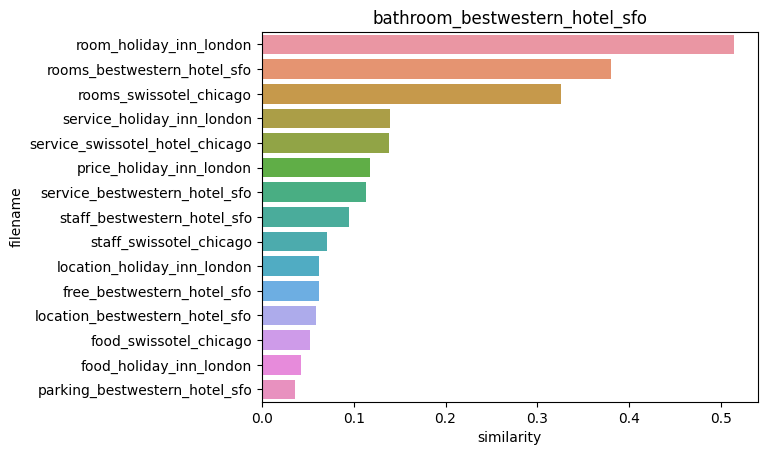

In [8]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 첫 번째 문서와 타 문서 간 유사도가 큰 순으로 정렬한 인덱스를 추출하되 자기 자신은 제외.
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:,1:]

# 유사도가 큰 순으로 hotel_indexes를 추출해 재정렬
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 인덱스와 유사도 값을 이용해 파일명과 유사도 값을 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x='similarity', y='filename', data=hotel_1_sim_df)
plt.title(comparison_docname)

# 09 한글 텍스트 처리 - 네이버 영화 평점 감성 분석

**한글 NLP 처리의 어려움**

* 띄어쓰기나 다양한 조사 때문에 한글 언어 처리가 어려움
* 영어는 띄어쓰기를 잘못하면 대부분 없는 단어로 인식하지만 한글은 의미가 왜곡되어 전달될 수 있음
* 조사의 경우의 수가 워낙에 많아 어근 추출 등 전처리 시 제거하기가 까다로움 + 조사를 의미가 있는 단어와 구분하기가 어려움

**KoNLPy 소개**
* 대표적인 한글 형태소(단어로서 의미를 가지는 최소 단위) 패키지
* 형태소 분석: 말뭉치를 형태소 어근 단위로 쪼개고 각 형태소에 품사 태깅을 부착하는 작업

In [1]:
pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 44.5 MB/s eta 0:00:00


In [22]:
import pandas as pd

train_df = pd.read_csv('ratings_train.txt',sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


-> 1이 긍정, 0이 부정 감성

In [23]:
train_df['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

-> 0,1 비율이 균등한 분포를 나타냄, document 칼럼에 null이 일부 존재하는 것+숫자로 구성된 경우에 공백으로 변환

In [24]:
import re

train_df = train_df.fillna(' ')
# 정규 표현식을 이용해 숫자를 공백으로 변경 (정규 표현식으로 \d는 숫자를 의미함)
train_df['document'] = train_df['document'].apply(lambda x: re.sub(r'\d+',' ',x))

# 테스트 데이터 세트를 로딩하고 동일하게 Null 및 숫자를 공백으로 변환
test_df = pd.read_csv('ratings_test.txt',sep='\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply(lambda x: re.sub(r'\d+',' ',x))

# id 칼럼 삭제 수행
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

* 한글 형태소 분석을 통해 형태소 단어로 토큰화하기
* twitter 클래스의 morphs() 메서드를 이용하면 입력 인자로 들어온 문장을 형태소 단어 형태로 토큰화하여 list 객체로 반환

In [25]:
from konlpy.tag import Twitter

twitter = Twitter()
def tw_tokenizer(text):
  # 입력 인자로 들어온 텍스트를 형태소 단어로 토큰화해 리스트 형태로 변환
  tokens_ko = twitter.morphs(text)
  return tokens_ko

/usr/local/lib/python3.10/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


* 사이킷런의 TfidfVectorizer를 이용해 tf-idf 피처 모델 생성

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Twitter 객체의 morphs() 객체를 이용한 tokenizer를 사용. ngram_range는 (1,2)
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


* 로지스틱 회귀를 이용해 분류 기반 감성 분석 수행

In [29]:
# 로지스틱 회귀를 이용해 감성 분석 분류 수행.
lg_clf = LogisticRegression(random_state = 0)

# 파라미터 C 최적화를 위해 GridSearchCV를 이용
params = {"C": [1, 3.5, 4.5, 5.5, 10]}
grid_cv = GridSearchCV(lg_clf, param_grid = params, cv = 3, scoring = "accuracy", verbose = 1)
grid_cv.fit(tfidf_matrix_train, train_df["label"])
print(grid_cv.best_params_, round(grid_cv.best_score_, 4))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

{'C': 3.5} 0.8593


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
from sklearn.metrics import accuracy_score

# 학습 데이터를 적용한 TfidfVectorizer를 이용해 테스트 데이터를 TF-IDF 값으로 피처 변환함.
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

# classifier는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
best_estimator = grid_cv.best_estimator_
preds = best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도:', accuracy_score(test_df['label'],preds))

Logistic Regression 정확도: 0.86186
